In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.5 MB/s eta 0:00:00


In [ ]:
!pip install librosa --upgrade


In [ ]:
import resampy  # Pre-import to fix lazy loading issue
import librosa


In [ ]:
!pip install librosa

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [ ]:
import os
import librosa

dataset_path = '/content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE'

# Function to walk through dataset and load audio
def load_all_audio(dataset_path):
    audio_data = []
    labels = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    audio_data.append(y)
                    labels.append(os.path.basename(root))  # Label = folder name
                    print(f"Loaded: {file_path}")
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")
    return audio_data, labels

audio_data, labels = load_all_audio(dataset_path)


Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine3_heavyload/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine1_good/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine2_broken/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_20.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_1.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_2.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_27.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_30.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_16.wav
Loaded: /content/

In [ ]:
import os



def count_audio_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.wav'):
                count += 1
    return count

total_files = count_audio_files(dataset_path)
print(f"Total audio files: {total_files}")


Total audio files: 2408


In [ ]:
import os
def count_audio_files_per_folder(path):
    folder_counts = {}
    total_count = 0

    for root, dirs, files in os.walk(path):
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            relative_folder = os.path.relpath(root, dataset_path)
            folder_counts[relative_folder] = len(wav_files)
            total_count += len(wav_files)

    return folder_counts, total_count

folder_counts, total_files = count_audio_files_per_folder(dataset_path)

# Print results
print(f"Total .wav audio files: {total_files}\n")
print("Files per folder:")
for folder, count in folder_counts.items():
    print(f"{folder}: {count} file(s)")


Total .wav audio files: 2408

Files per folder:
train/engine3_heavyload: 1 file(s)
train/engine1_good: 1 file(s)
train/engine2_broken: 1 file(s)
test_cut/engine3_heavyload: 687 file(s)
test_cut/engine1_good: 669 file(s)
test_cut/engine2_broken: 665 file(s)
train_cut/engine1_good: 105 file(s)
train_cut/engine3_heavyload: 128 file(s)
train_cut/engine2_broken: 124 file(s)
test/engine3_heavyload: 9 file(s)
test/engine1_good: 9 file(s)
test/engine2_broken: 9 file(s)


In [ ]:
def load_features_and_labels(data_path):
    features = []
    labels = []

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = os.path.basename(root)  # folder name as label
                mfcc = extract_features(file_path)
                if mfcc is not None:
                    features.append(mfcc)
                    labels.append(label)

    return np.array(features), labels


In [ ]:
def extract_features(file_path, n_mfcc=40):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
import resampy
print("✅ resampy is ready to go!")


✅ resampy is ready to go!


In [ ]:
import os
import librosa
import numpy as np
from collections import defaultdict

# Set max_files_per_class to None to load all files
def extract_mfcc(y, sr, n_mfcc=40, max_pad_len=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc.T  # shape: (time, n_mfcc)

def load_audio_from_each_class(dataset_path, max_files_per_class=None):
    features = []
    labels = []
    file_count = defaultdict(int)

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                class_label = os.path.basename(root)

                # Only skip if a max is defined
                if max_files_per_class is not None and file_count[class_label] >= max_files_per_class:
                    continue

                file_path = os.path.join(root, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    mfcc = extract_mfcc(y, sr)
                    features.append(mfcc)
                    labels.append(class_label)
                    file_count[class_label] += 1
                    print(f"Loaded: {file_path}")
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")

    print(f"\n🎯 Total Extracted Audio Files: {len(features)}")
    print("\n📊 Extracted Samples per Class:")
    for cls, count in file_count.items():
        print(f"  {cls}: {count} file(s)")
    return features, labels

# 👇 Call the function with no max limit
features, labels = load_audio_from_each_class(dataset_path, max_files_per_class=None)



Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine3_heavyload/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine1_good/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/train/engine2_broken/pure.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_20.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_1.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_2.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_27.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_30.wav
Loaded: /content/drive/MyDrive/Motor_Dataset/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_16.wav
Loaded: /content/

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)  # labels from your extracted data


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to ensure uniform input shape
X_padded = pad_sequences(features, padding='post', dtype='float32')  # shape = (samples, time_steps, n_mfcc)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# One-hot encode targets
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,115 (539.51 KB)

 Trainable params: 138,115 (539.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(627), np.int64(1): np.int64(639), np.int64(2): np.int64(660)}


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    LSTM(64, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(3, activation='softmax')  # Assuming 3 classes
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stop]
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7305 - loss: 3.0662 - val_accuracy: 1.0000 - val_loss: 1.3494
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9960 - loss: 1.1821 - val_accuracy: 1.0000 - val_loss: 0.6750
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9989 - loss: 0.6096 - val_accuracy: 1.0000 - val_loss: 0.3937
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9921 - loss: 0.4246 - val_accuracy: 0.9974 - val_loss: 0.3206
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9856 - loss: 0.3727 - val_accuracy: 0.9974 - val_loss: 0.2647
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.2485 - val_accuracy: 1.0000 - val_loss: 0.1932
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.1954 - val_accuracy: 1.0000 - val_loss: 0.1537
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.1585 - val_accuracy: 1.0000 - 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.1096 - val_accuracy: 0.9974 - val_loss: 0.1066
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9915 - loss: 0.1567 - val_accuracy: 0.9948 - val_loss: 0.1199
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9984 - loss: 0.1171 - val_accuracy: 0.9974 - val_loss: 0.1105
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9990 - loss: 0.0956 - val_accuracy: 0.9974 - val_loss: 0.0794
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 0.0829 - val_accuracy: 0.9922 - val_loss: 0.0940
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9969 - loss: 0.0828 - val_accuracy: 0.9974 - val_loss: 0.0820
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0824 - val_accuracy: 0.9948 - val_loss: 0.0984
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9997 - loss: 0.0684 - val_accuracy: 0.9845 - v

In [ ]:
import os
import librosa
import numpy as np
import random
from collections import defaultdict

# --- MFCC Extraction ---
def extract_mfcc(y, sr, n_mfcc=40, max_pad_len=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_pad_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc.T

# --- Load Audio ---
def load_audio_with_paths(dataset_path):
    features = []
    labels = []
    file_paths = []
    file_count = defaultdict(int)

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                class_label = os.path.basename(root)
                file_path = os.path.join(root, file)

                try:
                    y, sr = librosa.load(file_path, sr=None)
                    mfcc = extract_mfcc(y, sr)
                    features.append(mfcc)
                    labels.append(class_label)
                    file_paths.append(file_path)
                    file_count[class_label] += 1
                    print(f"✅ Loaded: {file_path}")
                except Exception as e:
                    print(f"❌ Failed to load {file_path}: {e}")

    print(f"\n🎯 Total Extracted Audio Files: {len(features)}")
    print("📊 Extracted Samples per Class:")
    for cls, count in file_count.items():
        print(f"  {cls}: {count} file(s)")

    return features, labels, file_paths, sr  # Return sampling rate

# --- Augment Audio ---
def add_noise(y, noise_factor=0.005):
    return y + noise_factor * np.random.randn(len(y))

def time_stretch(y, rate=1.0):
    return librosa.effects.time_stretch(y, rate)

def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def augment_dataset(features, labels, file_paths, sr, augment_per_sample=2):
    augmented_features = []
    augmented_labels = []

    for i, file_path in enumerate(file_paths):
        label = labels[i]
        try:
            y, _ = librosa.load(file_path, sr=sr)

            aug_methods = [
                add_noise,
                lambda d: time_stretch(d, rate=0.9),
                lambda d: time_stretch(d, rate=1.1),
                lambda d: pitch_shift(d, sr, n_steps=2),
                lambda d: pitch_shift(d, sr, n_steps=-2)
            ]
            selected = random.sample(aug_methods, augment_per_sample)

            for func in selected:
                y_aug = func(y)
                mfcc_aug = extract_mfcc(y_aug, sr)
                augmented_features.append(mfcc_aug)
                augmented_labels.append(label)

            print(f"✅ Augmented: {file_path}")

        except Exception as e:
            print(f"❌ Augmentation failed for {file_path}: {e}")

    final_features = features + augmented_features
    final_labels = labels + augmented_labels

    print(f"\n✅ Augmentation Complete")
    print(f"Original samples: {len(features)}")
    print(f"Augmented samples: {len(augmented_features)}")
    print(f"Total samples: {len(final_features)}")
    return final_features, final_labels


In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Get predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
from sklearn.metrics import classification_report

# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Print classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))


📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       165

    accuracy                           1.00       482
   macro avg       1.00      1.00      1.00       482
weighted avg       1.00      1.00      1.00       482



<ipython-input-34-9359c3cc0c62>:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


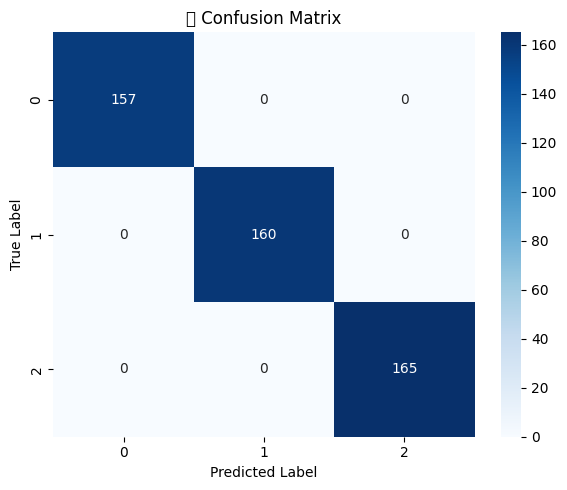

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📊 Confusion Matrix")
plt.tight_layout()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<ipython-input-35-ee5b6ae8fc22>:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


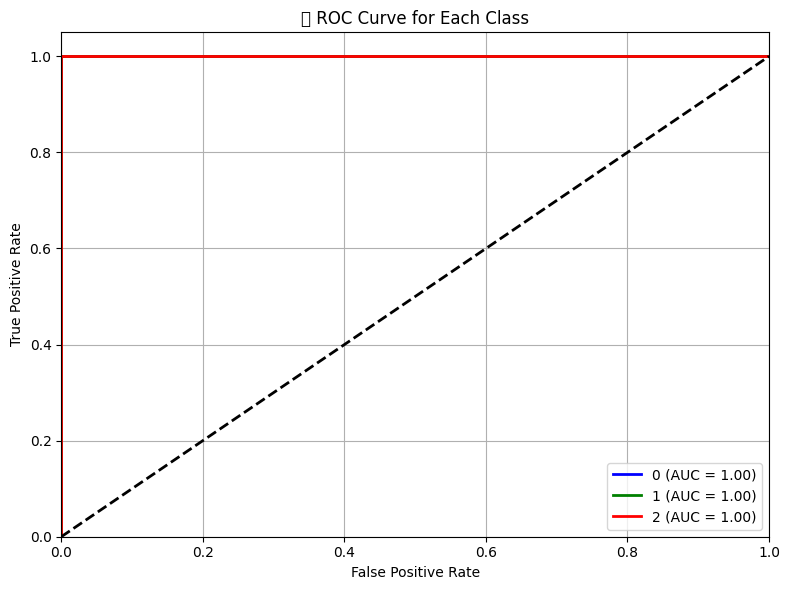

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Binarize the output for ROC
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
y_pred_prob = model.predict(X_test)

# 2. Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


T Test


In [ ]:
from scipy.stats import ttest_ind

# Convert labels to class names
labels_array = np.array(labels)

# Extract MFCC mean features per class
engine1 = [np.mean(f) for f, l in zip(features, labels_array) if l == 'engine1_good']
engine2 = [np.mean(f) for f, l in zip(features, labels_array) if l == 'engine2_broken']

# T-test
t_stat, p_val = ttest_ind(engine1, engine2)
print(f"🔍 T-Test between 'engine1_good' and 'engine2_broken': t = {t_stat:.4f}, p = {p_val:.4f}")


🔍 T-Test between 'engine1_good' and 'engine2_broken': t = 2.4822, p = 0.0132


Z-Test


In [ ]:
import statsmodels.api as sm
from scipy import stats  # Import scipy.stats

# Use the same groups
mean_diff = np.mean(engine1) - np.mean(engine2)
pooled_se = np.sqrt(np.var(engine1)/len(engine1) + np.var(engine2)/len(engine2))
z_score = mean_diff / pooled_se
p_val_z = 2 * (1 - stats.norm.cdf(abs(z_score))) # Changed sm.stats.norm.cdf to stats.norm.cdf

print(f"📏 Z-Test: z = {z_score:.4f}, p = {p_val_z:.4f}")


📏 Z-Test: z = 2.4813, p = 0.0131


ANOVA Test

In [ ]:
from scipy.stats import f_oneway

engine3 = [np.mean(f) for f, l in zip(features, labels_array) if l == 'engine3_heavyload']

# ANOVA
f_stat, p_val_anova = f_oneway(engine1, engine2, engine3)
print(f"📊 ANOVA across all classes: F = {f_stat:.4f}, p = {p_val_anova:.4f}")


📊 ANOVA across all classes: F = 3747.8127, p = 0.0000
